In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df =pd.read_csv("weather_forecast.csv")

In [3]:
df.head()

,Outlook,Temperature,Humidity,Windy,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [12]:
X = df[['Outlook', 'Temperature', 'Humidity', 'Windy']]
y = df['Play']

# Convert categorical data to numerical
X = pd.get_dummies(X, drop_first=True)
y = y.map({'Yes': 1, 'No': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

In [13]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Confusion Matrix:
[[1 1]
 [1 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.67      0.67      0.67         3

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5

Accuracy: 0.60


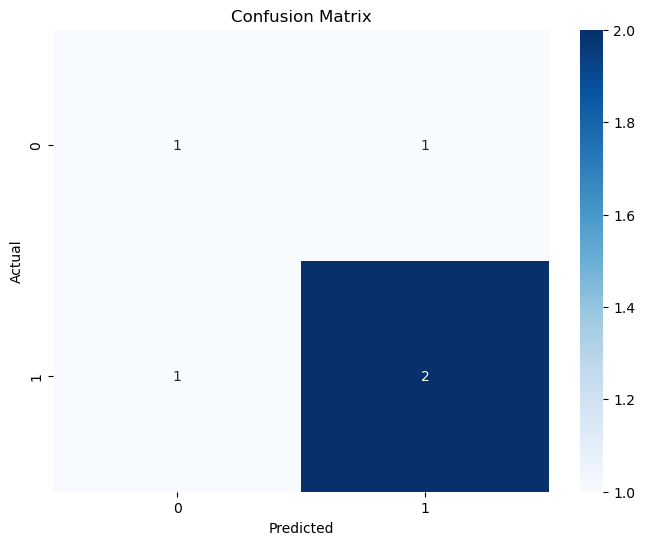

In [14]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Making predictions with new input
new_data = pd.DataFrame({
    'Outlook': ['Sunny'],
    'Temperature': ['Mild'],
    'Humidity': ['Normal'],
    'Windy': ['Weak']
})

new_data_encoded = pd.get_dummies(new_data, drop_first=True)
new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)  # Align with training data
prediction = model.predict(new_data_encoded)

print(f"Prediction for input {new_data.iloc[0].to_dict()}: {'Yes' if prediction[0] == 1 else 'No'}")

Prediction for input {'Outlook': 'Sunny', 'Temperature': 'Mild', 'Humidity': 'Normal', 'Windy': 'Weak'}: No


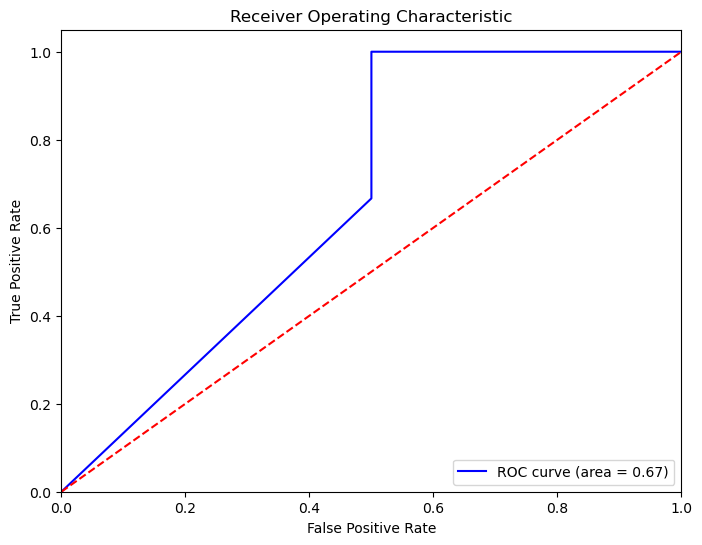

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Function to calculate prior probabilities
def calculate_priors(df):
    priors = {}
    total_count = len(df)
    
    for label in df['Play'].unique():
        priors[label] = len(df[df['Play'] == label]) / total_count
    
    return priors

# Function to calculate likelihoods
def calculate_likelihoods(df):
    likelihoods = {}
    
    for feature in df.columns[:-1]:  # Exclude the last column (target variable)
        likelihoods[feature] = {}
        for label in df['Play'].unique():
            subset = df[df['Play'] == label]
            feature_freq = subset[feature].value_counts(normalize=True).to_dict()
            likelihoods[feature][label] = feature_freq
    return likelihoods

# Function to predict the class
def predict(instance, priors, likelihoods):
    results = {}
    
    for label in priors.keys():
        posterior = priors[label]
        for feature, value in instance.items():
            if value in likelihoods[feature][label]:
                posterior *= likelihoods[feature][label][value]
            else:
                posterior *= 0  # If the feature value was not seen during training
        
        results[label] = posterior
    
    # Make the prediction based on results
    predicted_class = max(results, key=results.get)
    return predicted_class

# Calculate prior probabilities and likelihoods
priors = calculate_priors(df)
likelihoods = calculate_likelihoods(df)

# New instance to predict
new_instance = {
    'Outlook': 'Sunny',
    'Temperature': 'Mild',
    'Humidity': 'High',
    'Windy': 'Weak'
}

# Predict the class for the new instance
predicted_class = predict(new_instance, priors, likelihoods)
print(f'The predicted class for {new_instance} is: {"Yes" if predicted_class == 1 else "No"}')

The predicted class for {'Outlook': 'Sunny', 'Temperature': 'Mild', 'Humidity': 'High', 'Windy': 'Weak'} is: No
